In [2]:
# Data processing
import pandas as pd
import numpy as np
import seaborn as sns

# Standardize the data (padronização)
from sklearn.preprocessing import StandardScaler

# Modeling 
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings("ignore")
# color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/dataset_macau.csv')
# df = pd.read_csv('C:\projetos\jupyter_notebook\hyperparams_optimization\_data\dataset_macau.csv')
# Removendo todos as virgulas do dataset
df.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df.Data = pd.to_datetime(df.Data)

# Tranformando a coluna "Data" em index
df.set_index('Data', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')
df.head()

,Velocidade,Temperatura,Umidade,Pressão,Direção
Data,,,,,
2004-01-01,6.33,29.13,67.67,1010.97,11.00
2004-01-02,4.63,29.47,70.33,1010.67,5.67
2004-01-03,5.47,29.00,73.00,1010.20,7.67
2004-01-04,7.97,30.00,70.00,1009.57,10.67
2004-01-05,6.73,29.60,67.67,1009.03,11.00


In [4]:
df = df.drop(columns=['Temperatura','Umidade','Pressão','Direção'])
df

,Velocidade
Data,
2004-01-01,6.33
2004-01-02,4.63
2004-01-03,5.47
2004-01-04,7.97
2004-01-05,6.73
...,...
2017-05-27,3.76
2017-05-28,8.64
2017-05-29,8.88


Text(0, 0.5, 'Velocidade m/s²')

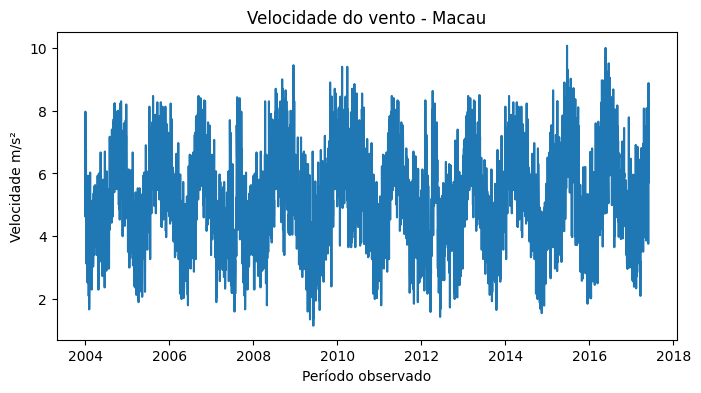

In [5]:
plt.subplots(figsize=(8,4))
plt.plot(df)
plt.title('Velocidade do vento - Macau')
plt.xlabel('Período observado')
plt.ylabel('Velocidade m/s²')

## Pré-processamento
> Separação dos dados em treino / teste

In [6]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) * set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [7]:
train, test = split_dataset(df, 0.75, True)


BASE DE TREINO
             Velocidade
Data                  
2014-01-18        4.87
2014-01-19        4.73
2014-01-20        6.87
2014-01-21        6.10
2014-01-22        7.40

BASE DE TESTE
             Velocidade
Data                  
2014-01-23        7.10
2014-01-24        7.10
2014-01-25        7.63
2014-01-26        5.53
2014-01-27        6.70


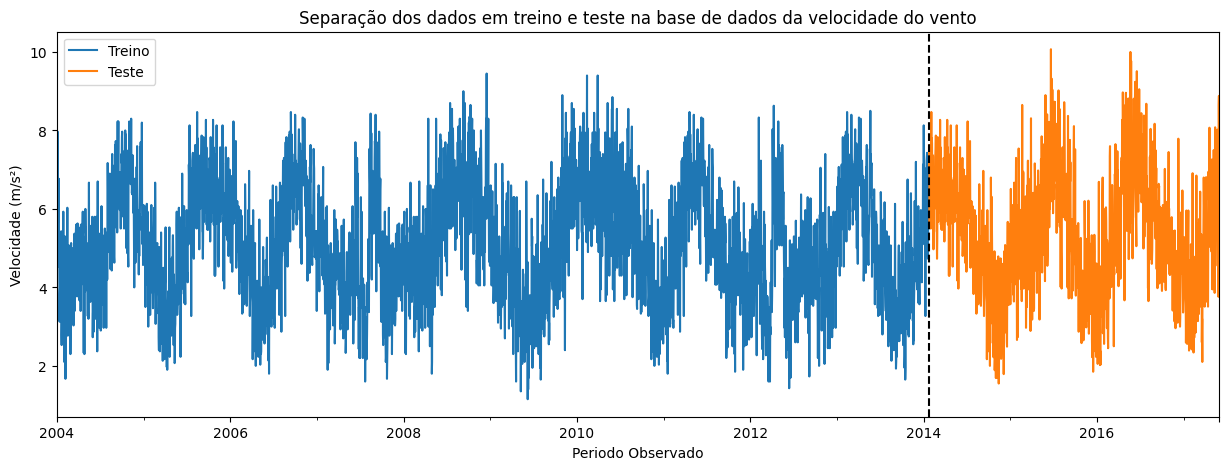

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Treino', title='Separação dos dados em treino e teste na base de dados da velocidade do vento')
test.plot(ax=ax, label='Teste')
ax.axvline('2014-01-22', color='black', ls='--')
ax.legend(['Treino', 'Teste'])
plt.xlabel("Periodo Observado")
plt.ylabel("Velocidade (m/s²)")
plt.show()

> Feature Engineering

In [9]:
def series_to_supervised(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['t-'+str(i)] = serie.shift(i)
    features = features.iloc[steps_in:] # remove linhas iniciais com nan
    return features

In [40]:
def lags(steps):
    lags_model = []
    for i in range(1, steps+1):
        # Feature Engireering
        train_data_features = series_to_supervised(train, steps_in=i)
        test_data_features = series_to_supervised(test, steps_in=i)

        # define X e y
        X_train = train_data_features.drop(columns=['t']).values
        y_train = train_data_features['t'].values.reshape(-1, 1)
        X_test = test_data_features.drop(columns=['t']).values
        y_test = test_data_features['t'].values.reshape(-1, 1)

        # padronização dos dados
        sc = StandardScaler()
        X_train_transformed = pd.DataFrame(sc.fit_transform(X_train))
        X_test_transformed = pd.DataFrame(sc.transform(X_test))

        # Define o modelo com os parametros padrões
        svr = SVR()
        svr.fit(X_train_transformed, y_train)

        # Verifica a acurácia
        score = svr.score(X_test_transformed, y_test)
        lags_model.append(score)
        print(f'O ponto de acurácia do modelo com {i} lags tem {score:.4f}')
    print("\n===================================================")
    print("Melhor pontuação de acurárcia: {:.4f}".format(max(lags_model)))
    print("===================================================")
lags(140)

O ponto de acurácia do modelo com 1 lags tem 0.3971
O ponto de acurácia do modelo com 2 lags tem 0.4245
O ponto de acurácia do modelo com 3 lags tem 0.4237
O ponto de acurácia do modelo com 4 lags tem 0.4470
O ponto de acurácia do modelo com 5 lags tem 0.4543
O ponto de acurácia do modelo com 6 lags tem 0.4654
O ponto de acurácia do modelo com 7 lags tem 0.4671
O ponto de acurácia do modelo com 8 lags tem 0.4886
O ponto de acurácia do modelo com 9 lags tem 0.4934
O ponto de acurácia do modelo com 10 lags tem 0.4983
O ponto de acurácia do modelo com 11 lags tem 0.4959
O ponto de acurácia do modelo com 12 lags tem 0.4940
O ponto de acurácia do modelo com 13 lags tem 0.4984
O ponto de acurácia do modelo com 14 lags tem 0.4996
O ponto de acurácia do modelo com 15 lags tem 0.5024
O ponto de acurácia do modelo com 16 lags tem 0.5023
O ponto de acurácia do modelo com 17 lags tem 0.5039
O ponto de acurácia do modelo com 18 lags tem 0.5141
O ponto de acurácia do modelo com 19 lags tem 0.5091
O 